<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from matplotlib import rcParams
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
rcParams['figure.figsize'] = 15, 5
palette = ["#202c39", "#283845", "#b8b08d", "#f2d492", "#f29559"]
rnd_data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=0).sort_index()
rnd_data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
rnd_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
rnd_data.index.is_monotonic

True

Данные указаны с периодичностью 10 минут.
Наша задача — прогноз на следующий час. Необходимо изменить интервал.

In [ ]:
rnd_data = rnd_data.resample('1H').sum()
data = rnd_data.copy()
find_rolling_data = rnd_data.copy()
rnd_data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000



Вывод
Загрузил данные и задал временной ряд через индекс.
Ресемплировал данные по одному часу.

## Анализ

In [ ]:
rnd_data['rolling_mean'] = rnd_data.rolling(100).mean()
rnd_data['dayofweek'] = rnd_data.index.dayofweek
rnd_data['hour'] = rnd_data.index.hour

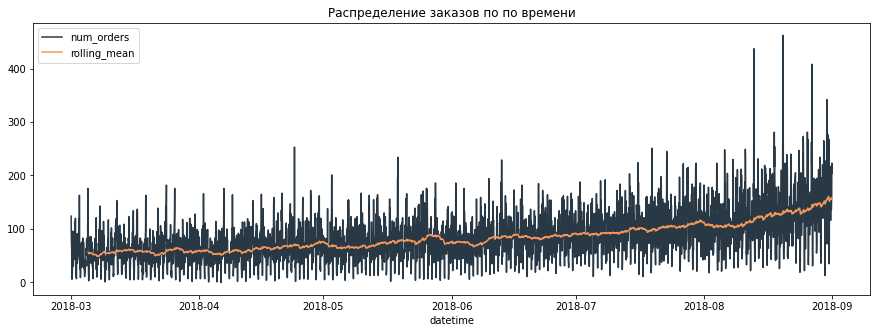

In [ ]:
fig = sns.lineplot(data=rnd_data[['num_orders', 'rolling_mean']], palette=["#283845", "#f29559"], dashes=False)
plt.title('Распределение заказов по по времени')
plt.show()

In [ ]:
data_pivot = pd.pivot_table(rnd_data, values='num_orders', index='dayofweek', aggfunc='mean')


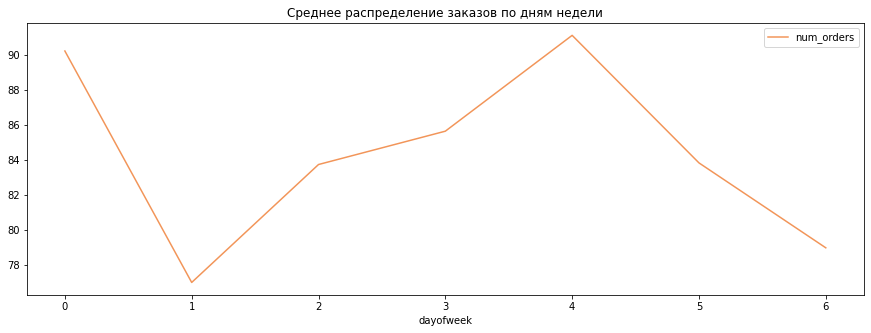

In [ ]:
data_pivot.plot(c='#F29559')
plt.title('Среднее распределение заказов по дням недели')
plt.show()

Определение ширины сдвига

In [ ]:
data_pivot = pd.pivot_table(rnd_data, values='num_orders', index='hour', aggfunc='mean')

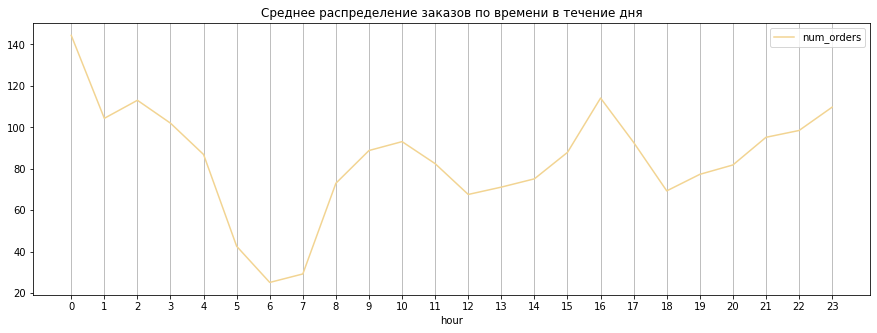

In [ ]:
data_pivot.plot(c=palette[3])
plt.title('Среднее распределение заказов по времени в течение дня')
plt.xticks(range(24))
plt.grid(axis='x')
plt.show()

In [ ]:
BEST_LAG = 18

In [ ]:
decomposed = seasonal_decompose(rnd_data['num_orders'])

Тренды и сезонность

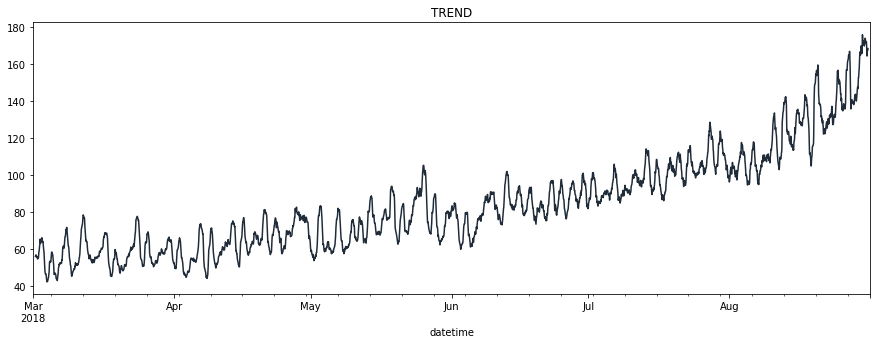

In [ ]:
decomposed.trend.plot(c=palette[0])
plt.title('TREND')
plt.show()

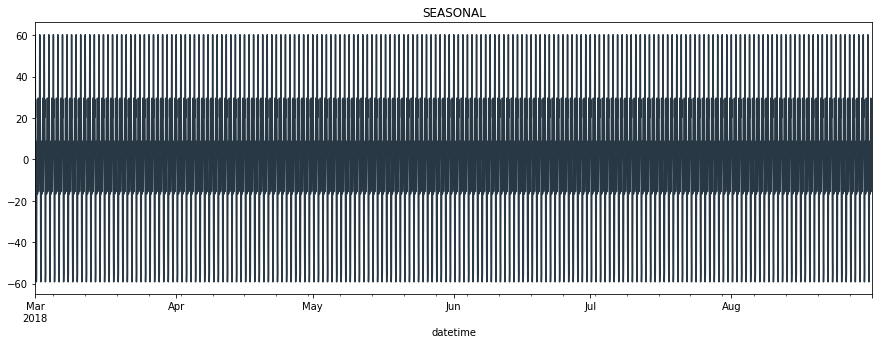

In [ ]:
decomposed.seasonal.plot(c=palette[1])
plt.title('SEASONAL')
plt.show()

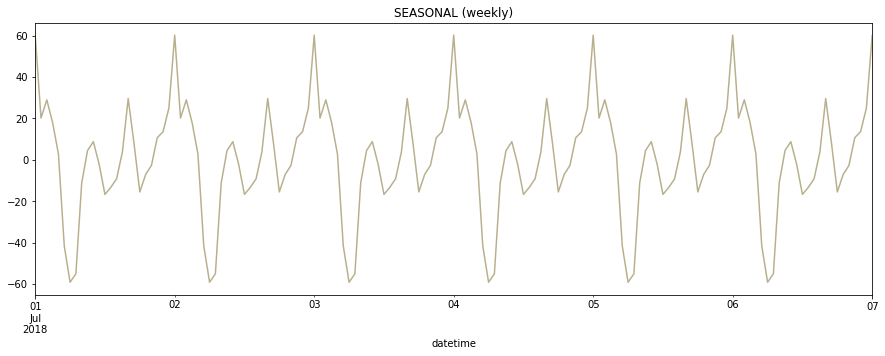

In [ ]:
decomposed.seasonal.plot(c=palette[2])
plt.title('SEASONAL (weekly)')
plt.xlim(('2018-07-01', '2018-07-07'))
plt.show()

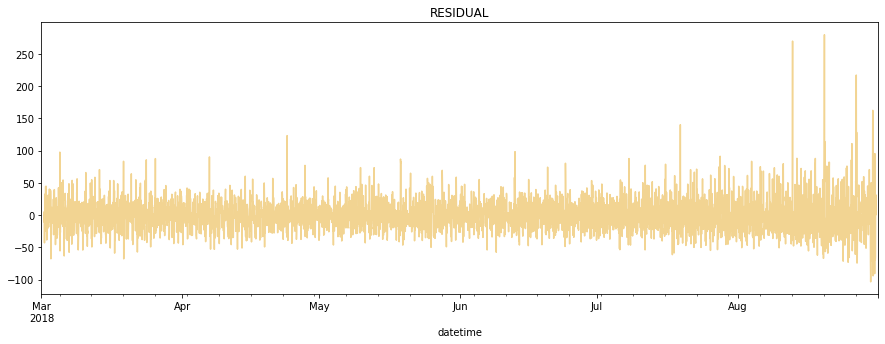

In [ ]:
decomposed.resid.plot(c=palette[3])
plt.title('RESIDUAL')
plt.show()

Определение размера скользящего окна

In [ ]:
best_rmse = 1000
best_rolling_size = 0
for rolling_size in range(1, 50, 1):
    find_rolling_data['rolling_mean'] = find_rolling_data['num_orders'].shift().rolling(rolling_size).mean()
    find_rolling_data.dropna(inplace=True)
    rmse = mean_squared_error(find_rolling_data['num_orders'], find_rolling_data['rolling_mean']) ** 0.5
    if rmse < best_rmse:
        best_rmse = rmse
        best_rolling_size = rolling_size
print(
    f'RMSE: {best_rmse:.2f}\n'
    f'Размер скользящего окна: {best_rolling_size}\n'
)

RMSE: 37.50
Размер скользящего окна: 26



Создание признаков

In [ ]:
data['hour'] = data.index.hour
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek

for lag in range(1, BEST_LAG + 1):
    data[f'lag_{lag}'] = data['num_orders'].shift(lag)

data['rolling_mean'] = data['num_orders'].shift().rolling(best_rolling_size).mean()

Подготовка выборок

In [ ]:
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=12345)
train = train.dropna()

target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

print(
    f'Выборка разделена в пропорциях:\n'
    f'{(len(features_train)/len(data)):.0%} — тренировочная;\n'
    f'{(len(features_test)/len(data)):.0%} — тестовая;\n'
)

Выборка разделена в пропорциях:
89% — тренировочная;
10% — тестовая;



Вывод

Виден общий тренд на увеличение заказов.

В среднем больше всего заказов в понедельник и четверг.

В среднем меньше всего заказов во вторник и в воскресенье.

В среднем пиковая нагрузка приходится на полночь.

В среднем меньше всего заказов между пятью и семью утра.

Исходя из экстремумов количества заказов, размер сдвига возьму равным 18 часам.

(24:00:00 - 06:00:00)

Определил наиболее подходящий размер скользящего окна: 26.

Создал признаки для обучения и тестирования моделей.

При подготовке выборок отказался от валидационной выборки,
потому что не получалось добиться подходящих результатов на тестовой выборке.

В Slack подсказали метод GridSearchCV для подбора параметров.

Но даже на полученных ранее параметрах получается добиться необходимых показателей RMSE.

## Обучение

In [ ]:
result = 'null'
splits = TimeSeriesSplit(n_splits=3)

Модель Случайный лес

In [ ]:
model = RandomForestRegressor(random_state=12345)
parameters = {
    'n_estimators': [40],
    'max_depth': [16],
}
rf_grid = GridSearchCV(model, parameters, cv=splits, n_jobs=-1)

In [ ]:
%%capture result
%%timeit
rf_grid.fit(features_train, target_train)

In [ ]:
rf_fit_time = result.stdout.split(' per loop ')[0]
models_compare = {
    'RandomForestRegressor': {
        'fit_time': rf_fit_time,
    },
}
models_statistics = pd.DataFrame(models_compare).T
models_statistics

,fit_time
RandomForestRegressor,3.86 s +- 41.5 ms


Модель CatBoostRegressor

In [ ]:
model = CatBoostRegressor(random_state=12345, verbose=False)
parameters = {
    'depth': [5, 8, 10],
    'learning_rate': [0.1, 0.5, 1],
}
cat_grid = model.grid_search(parameters, Pool(features_train, target_train), cv=splits, verbose=False)
best_depth = cat_grid['params']['depth']
best_learning_rate = cat_grid['params']['learning_rate']
cat_model = CatBoostRegressor(
    depth=best_depth,
    learning_rate=best_learning_rate,
    random_state=12345,
    verbose=False
)


bestTest = 32.10761258
bestIteration = 955


bestTest = 31.25498337
bestIteration = 30


bestTest = 31.64709529
bestIteration = 12


bestTest = 34.01140452
bestIteration = 536


bestTest = 35.29427258
bestIteration = 39


bestTest = 36.81309388
bestIteration = 16


bestTest = 36.60675017
bestIteration = 650


bestTest = 40.12117557
bestIteration = 109


bestTest = 42.15823765
bestIteration = 8

Training on fold [0/3]

bestTest = 27.79803315
bestIteration = 90

Training on fold [1/3]

bestTest = 26.64678231
bestIteration = 16

Training on fold [2/3]

bestTest = 31.71720885
bestIteration = 41



In [ ]:
%%capture result
%%timeit
cat_model.fit(features_train, target_train)

In [ ]:
cat_fit_time = result.stdout.split(' per loop ')[0]
models_compare['CatBoostRegressor'] = {
        'fit_time': cat_fit_time,
}
models_statistics = pd.DataFrame(models_compare).T
models_statistics

,fit_time
RandomForestRegressor,3.86 s +- 41.5 ms
CatBoostRegressor,3.99 s +- 78.3 ms


LinearRegression

In [ ]:
# Создаем пайплайн с масштабированием и моделью
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Масштабирование признаков
    ('model', LinearRegression())  # Модель
])

# Параметры для GridSearch (включая Ridge и Lasso)
parameters = [
    {
        'model': [LinearRegression()],
    },
    {
        'model': [Ridge()],
        'model__alpha': [0.1, 1.0, 10.0]  # Параметры регуляризации
    },
    {
        'model': [Lasso()],
        'model__alpha': [0.1, 1.0, 10.0],
        'model__max_iter': [10000]  # Увеличиваем итерации для сходимости
    }
]

# Настройка кросс-валидации
cv = KFold(n_splits=5, shuffle=True, random_state=12345)

# Создаем GridSearch
lr_grid = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [ ]:
%%capture result
%%timeit
lr_grid.fit(features_train, target_train)

In [ ]:
print(f"Лучшие параметры: {rf_grid.best_params_}")
print(f"Лучшая RMSE на кросс-валидации: {rf_grid.best_score_:.4f}")


print(f"Лучшие параметры: depth={best_depth}, learning_rate={best_learning_rate}")
print(f"Лучшая RMSE на кросс-валидации: {min(cat_grid['cv_results']['test-RMSE-mean'])}")


print("Лучшая модель:", lr_grid.best_params_)
print("Лучший RMSE:", np.sqrt(-lr_grid.best_score_))

Лучшие параметры: {'max_depth': 16, 'n_estimators': 40}
Лучшая RMSE на кросс-валидации: 0.4213
Лучшие параметры: depth=5, learning_rate=0.5
Лучшая RMSE на кросс-валидации: 29.067733423952244
Лучшая модель: {'model': Ridge(), 'model__alpha': 1.0}
Лучший RMSE: 28.819260124316934


Лучшей моделью себя показала RandomForest

Вывод

Обучил модели на параметрах,
полученных либо при разделении выборки на три группы (тренировочную, валидационную, тестовую),
либо методами подбора параметров.

## Тестирование

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Модель Случайный лес

In [ ]:
predictions = rf_grid.best_estimator_.predict(features_test)

In [ ]:
%%capture result
%%timeit
rf_grid.predict(features_test)

In [ ]:
forest_prediction_time = result.stdout.split(' per loop ')[0]

In [ ]:
forest_rmse = mean_squared_error(target_test, predictions) ** 0.5

In [ ]:
models_compare['RandomForestRegressor']['prediction_time'] = forest_prediction_time
models_compare['RandomForestRegressor']['rmse'] = forest_rmse
models_statistics = pd.DataFrame(models_compare).T
models_statistics

,fit_time,prediction_time,rmse
RandomForestRegressor,3.86 s +- 41.5 ms,7.77 ms +- 166 us,45.495317
CatBoostRegressor,3.99 s +- 78.3 ms,NaN,NaN


# Общий вывод:

При выполнении проекта проделана следующая работа:

На первом этапе произведена загрузка данных и их подготовка для обучения моделей

За время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа, которое скорее всего вызвано ростом компании, поскольку есть гипотеза, что бизнес, связанный с такси не имеет месячной сезонности. Но данную гипотезу можно подтвердить или опровергнуть только имея данные за несколько лет.На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.


На третьем этапе к датасету были добавлены дополнительные признаки, а именно день недели, час "отстающие значения" и скользящее среднее. На дополнном датасете подобраны оптимальные гиперпараметры для моделей.


На четвертом этапе проведено тестирование всех моделей, каждой из них удалось достичь требуемого показателя метрики RMSE. Анализ сравнительных графиков в двух масштабах, показал, что модели хуже всего справляются с предсказаниями на высоких пиках и на провалах, но в целом, угадывают направления движения. Наилучший показатель RMSE в данном случае у RandomForest = 45,4953.